In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/COMP4471_project/
!pip install albumentations==0.4.6

Mounted at /content/drive/
/content/drive/MyDrive/COMP4471_project


In [ ]:
import numpy as np
import pandas as pd
import os
import PIL.Image as Image
import torch.nn as nn
import torch
import torchvision
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import albumentations as A
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import random
from model import UNET, DoubleConv


## 1. Define model architecture

In [ ]:
# Unet sanity check
def test():
    x = torch.randn((3,3,256,256))
    model = UNET(3,1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
test()

torch.Size([3, 1, 256, 256])
torch.Size([3, 3, 256, 256])


## 2. Define dataset

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, face_dir, mask_dir, transform=None, mode='train', size=5000):

        self.face_dir = face_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # The two lists store the path of each image
        self.faces = []
        self.masks = []


        # prepare face and mask images path
        for i, filename in enumerate(os.listdir(face_dir)):

            if i >= size:
                break
            if filename.endswith(('.jpg')):

                self.faces.append(str(face_dir+filename))
                self.masks.append(str(mask_dir+filename.replace("jpg", "png")))

        assert len(self.masks) == len(self.faces), " Number of faces and masks are not the same!"

        # Train-Val split
        
        if mode == 'train':
            self.faces = self.faces[:int(0.7*size)]
            self.masks = self.masks[:int(0.7*size)]

        if mode == 'valid':
            self.faces = self.faces[int(0.7*size):int(0.9*size)]
            self.masks = self.masks[int(0.7*size):int(0.9*size)]

        if mode == 'test':
            self.faces = self.faces[int(0.9*size):]
            self.masks = self.masks[int(0.9*size):]

    def __len__(self):
        return len(self.faces)

    def __getitem__(self,i):
        # Returns a face and a mask
        img_path = self.faces[i]
        mask_path = self.masks[i]
    
        # Read and Normalize the image
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path), dtype=np.float32)
        
        mask /= 255
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
        return image, mask

In [ ]:
# Dataset sanity check
face_dir = 'datasets/matting_data/face/'
mask_dir = 'datasets/matting_data/mask/'

face_dataset = FaceDataset(face_dir, mask_dir, size=10)

def get_image_info(img):
    plt.imshow(img)
    print("shape of the image:", img.shape)
    print("value range of the image:", img.min(), img.max())

shape of the image: (800, 600, 3)
value range of the image: 0 255


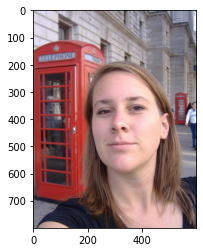

In [ ]:
# Show the human body image
face_img = face_dataset[3][0]
get_image_info(face_img)

shape of the image: (800, 600)
value range of the image: 0.0 1.0


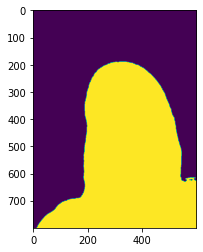

In [ ]:
# Show the mask
mask_img = face_dataset[3][1]
get_image_info(mask_img)

## 3. Train

### Training configurations

In [ ]:

Load_Model = True
# Load_Model = False

LR = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 16
max_epochs = 20
num_workers = 2
PIN_Memory = True

image_width = 256
image_height = 256

Train_Face_dir='datasets/matting_data/face/'
Train_Mask_dir='datasets/matting_data/mask/'

In [ ]:
def Loader(Img_dir, Mask_dir, train_transform, pin_memory, mode, size=5000):
    
    ds=FaceDataset(Img_dir, Mask_dir, train_transform, mode, size)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
  
def show_image(image, title=None, cmap=None):
    
    # transpose image
    image = np.transpose(image, [1,2,0])

    # if gray scale, reshape
    if image.shape[2] == 1:
        image = image.reshape((image.shape[0], image.shape[1]))

    plt.imshow(image, cmap=cmap)
    if title is not None : plt.title(title)
    plt.axis('off')

def map(image, mask, threshold=0.5):
    return np.where(mask>threshold, image, mask)

def check_accuracy(x, y, model, device='cpu'):
    num_correct = 0
    num_pixels = 0
    model.eval()
  
    N = x.shape[0]
    i = random.randint(0, N-1)

    with torch.no_grad():
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        preds = model(x).cpu()
        
        preds[preds < 0.5] = 0
        preds[preds >= 0.5] = 1

        masks = (preds>0.5).float()
        x = x.cpu()
        y = y.cpu()
    
        num_correct += (masks==y).sum()
        num_pixels += torch.numel(masks)
      
        plt.figure()

        plt.subplot(1, 4, 1)
        show_image(x[i], title="Original image")

        plt.subplot(1, 4, 2)
        show_image(preds[i], title="Predicted mask")

        plt.subplot(1, 4, 3)
        show_image(y[i], title="True mask")

        plt.subplot(1, 4, 4)
        show_image(map(x[i], preds[i]), title="Mapped image")

        plt.tight_layout()
        plt.savefig(str('/content/drive/MyDrive/COMP4471_project/results/' + 'unet%02d.png' % (epoch)))
        plt.show()
        
    print(f"pixel accuracy: {(num_correct/num_pixels)*100}")
    model.train()
    

In [ ]:
transform = A.Compose([A.Resize(height=image_height, width=image_width),
                       A.Normalize(mean=[0.0,0.0,0.0], std=[1.0,1.0,1.0], max_pixel_value=255.0),
                       ToTensorV2()])

In [ ]:
def train_fn(loader, model, optimzier, loss_fn, scaler, validation=None):
    model.train()
    loop = tqdm(loader)
    for i, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.float().unsqueeze(1).to(device)

        #Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions,targets)

        optimzier.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimzier)
        scaler.update()
        loop.postfix = f"Loss is {loss.item()}"
        if i % 50 == 0 and not validation == None:
            #print("Iteration", i+1)
            X_val, Y_val = next(iter(validation))
            check_accuracy(X_val, Y_val, model, device)
            

In [ ]:
# Prepare model, loss function, optimizer and scaler for training
model = UNET(in_c=3, o_c=1)

# Actively modify this part for continue training
if Load_Model == True:
      model = torch.load('/content/drive/MyDrive/COMP4471_project/models/Unet/model_full_unetv4.pth')

model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(model.parameters(),lr=LR,weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

epoch 0


100%|██████████| 1/1 [00:16<00:00, 16.05s/it, Loss is 0.7217677235603333]


model output shape: torch.Size([4, 1, 256, 256])


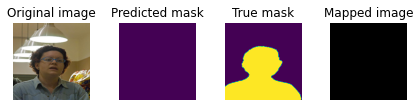

pixel accuracy: 49.56169128417969
epoch 1


100%|██████████| 1/1 [00:00<00:00,  1.57it/s, Loss is 0.6462035179138184]


model output shape: torch.Size([4, 1, 256, 256])


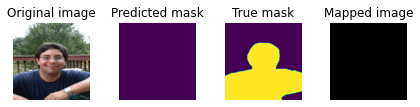

pixel accuracy: 49.56169128417969
epoch 2


100%|██████████| 1/1 [00:00<00:00,  1.79it/s, Loss is 0.6268855333328247]


model output shape: torch.Size([4, 1, 256, 256])


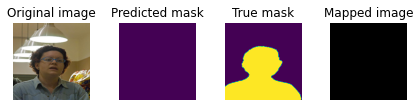

pixel accuracy: 49.56169128417969


In [ ]:
# train with dev dataset
dev_train = Loader(Train_Face_dir, Train_Mask_dir, transform, PIN_Memory, 'train', 20)
dev_valid = Loader(Train_Face_dir, Train_Mask_dir, transform, PIN_Memory, 'valid', 20)

for epoch in range(3):

    print("epoch", epoch)
    train_fn(dev_train, model, optimizer, loss_fn, scaler)

    X_val, Y_val = next(iter(dev_valid))
    check_accuracy(X_val, Y_val, model, device)


In [ ]:
train_data = Loader(Train_Face_dir, Train_Mask_dir, transform, PIN_Memory, 'train', 3000)
valid_data = Loader(Train_Face_dir, Train_Mask_dir, transform, PIN_Memory, 'valid', 3000)
test_data = Loader(Train_Face_dir, Train_Mask_dir, transform, PIN_Memory, 'test', 3000)

epoch 6


  0%|          | 0/132 [00:00<?, ?it/s]

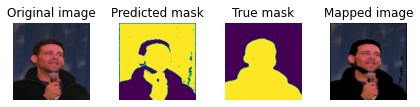

  1%|          | 1/132 [00:16<35:40, 16.34s/it, Loss is 0.5254133939743042]

pixel accuracy: 64.11018371582031


 38%|███▊      | 50/132 [06:47<11:42,  8.57s/it, Loss is 0.5027735829353333]

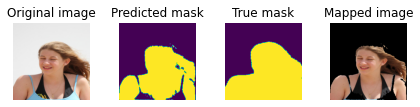

 39%|███▊      | 51/132 [07:04<14:36, 10.82s/it, Loss is 0.4661902189254761]

pixel accuracy: 78.50780487060547


 76%|███████▌  | 100/132 [13:21<03:49,  7.18s/it, Loss is 0.42311108112335205]

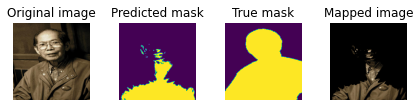

 77%|███████▋  | 101/132 [13:39<05:22, 10.42s/it, Loss is 0.306087464094162]  

pixel accuracy: 80.24168395996094


100%|██████████| 132/132 [17:47<00:00,  8.09s/it, Loss is 0.3741026818752289]


epoch 7


  0%|          | 0/132 [00:00<?, ?it/s]

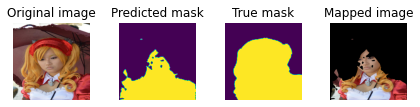

  1%|          | 1/132 [00:08<18:00,  8.25s/it, Loss is 0.3886406719684601]

pixel accuracy: 82.91854858398438


 38%|███▊      | 50/132 [00:41<00:55,  1.49it/s, Loss is 0.2813543677330017] 

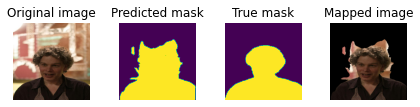

 39%|███▊      | 51/132 [00:49<03:48,  2.82s/it, Loss is 0.28712260723114014]

pixel accuracy: 88.79461669921875


 76%|███████▌  | 100/132 [01:22<00:21,  1.52it/s, Loss is 0.26880669593811035]

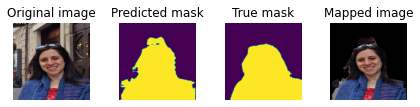

 77%|███████▋  | 101/132 [01:30<01:34,  3.03s/it, Loss is 0.27079713344573975]

pixel accuracy: 88.466552734375


100%|██████████| 132/132 [01:50<00:00,  1.19it/s, Loss is 0.2749086618423462]


epoch 8


  0%|          | 0/132 [00:00<?, ?it/s]

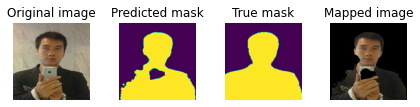

  1%|          | 1/132 [00:05<12:43,  5.83s/it, Loss is 0.31402263045310974]

pixel accuracy: 89.41631317138672


 38%|███▊      | 50/132 [00:39<00:54,  1.50it/s, Loss is 0.2517894506454468] 

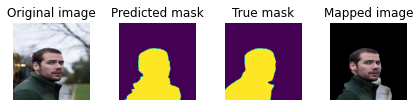

 39%|███▊      | 51/132 [00:45<03:04,  2.28s/it, Loss is 0.23371118307113647]

pixel accuracy: 86.97261810302734


 76%|███████▌  | 100/132 [01:17<00:22,  1.45it/s, Loss is 0.21396559476852417]

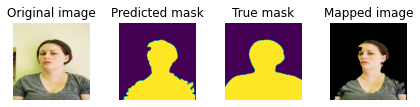

 77%|███████▋  | 101/132 [01:27<01:48,  3.49s/it, Loss is 0.2008129358291626] 

pixel accuracy: 92.4234390258789


100%|██████████| 132/132 [01:47<00:00,  1.22it/s, Loss is 0.23001526296138763]


epoch 9


  0%|          | 0/132 [00:00<?, ?it/s]

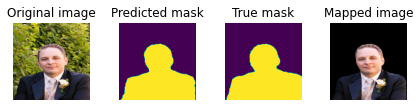

  1%|          | 1/132 [00:05<12:31,  5.73s/it, Loss is 0.18155363202095032]

pixel accuracy: 92.11921691894531


 38%|███▊      | 50/132 [00:39<00:54,  1.50it/s, Loss is 0.21177510917186737]

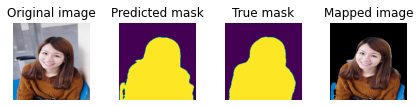

 39%|███▊      | 51/132 [00:46<03:25,  2.53s/it, Loss is 0.2690395712852478] 

pixel accuracy: 91.08505249023438


 76%|███████▌  | 100/132 [01:18<00:21,  1.50it/s, Loss is 0.17442557215690613]

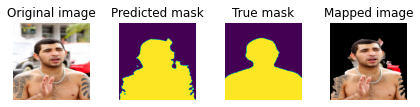

 77%|███████▋  | 101/132 [01:23<01:02,  2.02s/it, Loss is 0.20343142747879028]

pixel accuracy: 92.23661804199219


100%|██████████| 132/132 [01:44<00:00,  1.27it/s, Loss is 0.17905429005622864]


epoch 10


  0%|          | 0/132 [00:00<?, ?it/s]

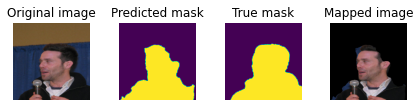

  1%|          | 1/132 [00:09<20:54,  9.57s/it, Loss is 0.21410702168941498]

pixel accuracy: 92.1762466430664


 38%|███▊      | 50/132 [00:42<00:54,  1.50it/s, Loss is 0.19990961253643036]

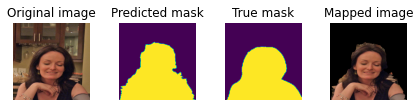

 39%|███▊      | 51/132 [00:48<03:16,  2.43s/it, Loss is 0.17376242578029633]

pixel accuracy: 91.39251708984375


 76%|███████▌  | 100/132 [01:21<00:21,  1.52it/s, Loss is 0.17270982265472412]

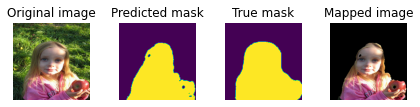

 77%|███████▋  | 101/132 [01:28<01:19,  2.56s/it, Loss is 0.2049432098865509] 

pixel accuracy: 92.1346664428711


100%|██████████| 132/132 [01:48<00:00,  1.22it/s, Loss is 0.18600569665431976]


epoch 11


  0%|          | 0/132 [00:00<?, ?it/s]

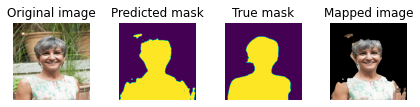

  1%|          | 1/132 [00:05<12:58,  5.94s/it, Loss is 0.16504310071468353]

pixel accuracy: 90.80972290039062


 38%|███▊      | 50/132 [00:38<00:54,  1.50it/s, Loss is 0.21804657578468323]

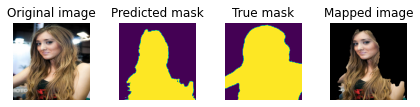

 39%|███▊      | 51/132 [00:44<02:55,  2.16s/it, Loss is 0.18223845958709717]

pixel accuracy: 91.5365219116211


 76%|███████▌  | 100/132 [01:17<00:21,  1.50it/s, Loss is 0.13051196932792664]

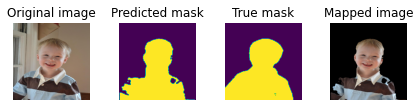

 77%|███████▋  | 101/132 [01:24<01:17,  2.50s/it, Loss is 0.17160631716251373]

pixel accuracy: 93.76763916015625


100%|██████████| 132/132 [01:44<00:00,  1.27it/s, Loss is 0.19251564145088196]


epoch 12


  0%|          | 0/132 [00:00<?, ?it/s]

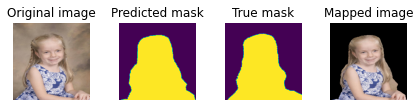

  1%|          | 1/132 [00:04<10:30,  4.81s/it, Loss is 0.22220441699028015]

pixel accuracy: 92.3349380493164


 38%|███▊      | 50/132 [00:38<00:54,  1.50it/s, Loss is 0.16509810090065002]

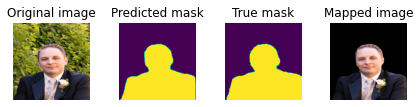

 39%|███▊      | 51/132 [00:41<02:00,  1.49s/it, Loss is 0.16686397790908813]

pixel accuracy: 94.78578186035156


 76%|███████▌  | 100/132 [01:14<00:22,  1.43it/s, Loss is 0.15539565682411194]

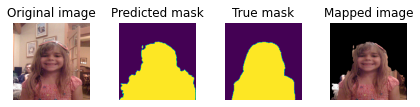

 77%|███████▋  | 101/132 [01:19<01:04,  2.09s/it, Loss is 0.14679551124572754]

pixel accuracy: 93.91928100585938


100%|██████████| 132/132 [01:40<00:00,  1.32it/s, Loss is 0.26263731718063354]


epoch 13


  0%|          | 0/132 [00:00<?, ?it/s]

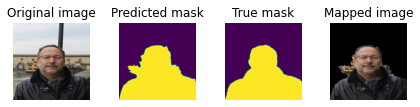

  1%|          | 1/132 [00:05<11:23,  5.22s/it, Loss is 0.2823774218559265]

pixel accuracy: 91.54425048828125


 38%|███▊      | 50/132 [00:38<00:59,  1.39it/s, Loss is 0.10111463069915771]

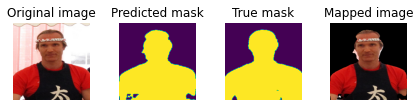

 39%|███▊      | 51/132 [00:46<03:56,  2.92s/it, Loss is 0.1131596714258194] 

pixel accuracy: 96.35820007324219


 76%|███████▌  | 100/132 [01:19<00:21,  1.51it/s, Loss is 0.1344469040632248]

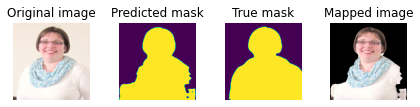

 77%|███████▋  | 101/132 [01:23<00:51,  1.66s/it, Loss is 0.1380588263273239]

pixel accuracy: 94.61221313476562


100%|██████████| 132/132 [01:43<00:00,  1.27it/s, Loss is 0.08485627174377441]


epoch 14


  0%|          | 0/132 [00:00<?, ?it/s]

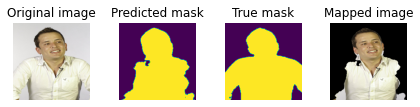

  1%|          | 1/132 [00:04<09:44,  4.46s/it, Loss is 0.13287273049354553]

pixel accuracy: 92.96769714355469


 38%|███▊      | 50/132 [00:37<00:54,  1.51it/s, Loss is 0.12065830826759338]

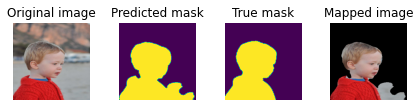

 39%|███▊      | 51/132 [00:42<02:51,  2.11s/it, Loss is 0.10184810310602188]

pixel accuracy: 93.52149963378906


 76%|███████▌  | 100/132 [01:15<00:21,  1.51it/s, Loss is 0.11821594089269638]

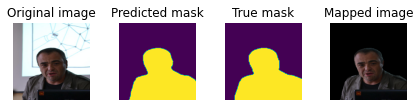

 77%|███████▋  | 101/132 [01:21<01:05,  2.13s/it, Loss is 0.09861563891172409]

pixel accuracy: 95.16620635986328


100%|██████████| 132/132 [01:41<00:00,  1.30it/s, Loss is 0.08434677124023438]


epoch 15


  0%|          | 0/132 [00:00<?, ?it/s]

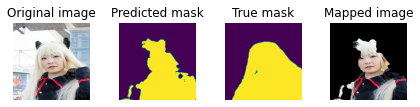

  1%|          | 1/132 [00:05<12:49,  5.87s/it, Loss is 0.10151737183332443]

pixel accuracy: 92.07276916503906


 38%|███▊      | 50/132 [00:38<00:55,  1.48it/s, Loss is 0.09252791106700897]

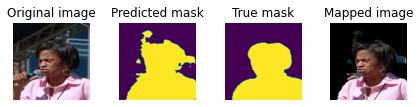

 39%|███▊      | 51/132 [00:44<03:03,  2.27s/it, Loss is 0.10356620699167252]

pixel accuracy: 95.15209197998047


 76%|███████▌  | 100/132 [01:18<00:21,  1.50it/s, Loss is 0.10970684885978699]

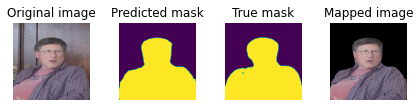

 77%|███████▋  | 101/132 [01:23<01:03,  2.05s/it, Loss is 0.08425336331129074]

pixel accuracy: 94.7011947631836


100%|██████████| 132/132 [01:43<00:00,  1.28it/s, Loss is 0.1045793741941452]


In [ ]:
for epoch in range(5, 15):

    print("epoch", epoch+1)
    train_fn(train_data, model, optimizer, loss_fn, scaler, valid_data)

    torch.save(model,'models/model_full_unetv{}.pth'.format(epoch))

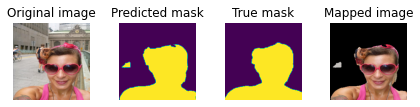

pixel accuracy: 97.2848892211914


In [ ]:
model = torch.load('/content/drive/MyDrive/COMP4471_project/models/Unet/model_full_unetv14.pth')
X_test, Y_test = next(iter(test_data))
check_accuracy(X_test, Y_test, model, device)
